In [2]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/jeremytan/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100.0%


In [3]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

In [4]:
import random

In [6]:
img = Image.open('./person.png')
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img])

In [7]:
pred[0]

{'boxes': tensor([[4270.0703, 1152.5651, 5702.9585, 5113.4824],
         [2559.8325, 1210.2130, 3765.6792, 5177.5420],
         [6492.1230, 2817.6008, 7383.3203, 4857.9409],
         [1855.8469, 3906.1323, 2413.2217, 4747.2715],
         [3691.2971, 4180.9780, 4936.4458, 5221.6465],
         [7260.3169, 3700.6694, 7891.0376, 4434.8726],
         [6106.2710, 4107.9487, 6419.4966, 4676.6953],
         [1787.3199, 3870.9111, 2195.4141, 4475.4917],
         [5556.0767, 3060.3157, 5656.9688, 3157.0681],
         [5308.4639, 3938.6919, 5772.6357, 4703.2178],
         [2748.8821, 2106.3872, 3783.9490, 3934.4082],
         [2891.3044, 2935.2598, 3759.3203, 3821.1975],
         [6545.5972, 3788.0330, 6770.1001, 4491.7310],
         [7236.1768, 3761.2705, 7509.1685, 4409.7935],
         [7126.0200, 4385.9595, 7549.5557, 4783.4956],
         [3383.1003, 1994.5723, 3790.0769, 3699.9768],
         [1785.6313, 4072.1013, 1953.8301, 4444.9272],
         [7463.0708, 4372.3066, 7870.0361, 4844.6753],
 

In [8]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape


(29, 5304, 7952)

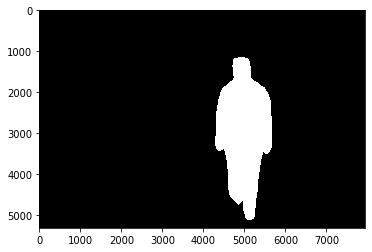

In [9]:
plt.imshow(masks[0], cmap='gray')
plt.show()

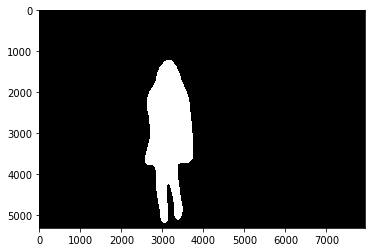

In [10]:
plt.imshow(masks[1], cmap='gray') 
plt.show()

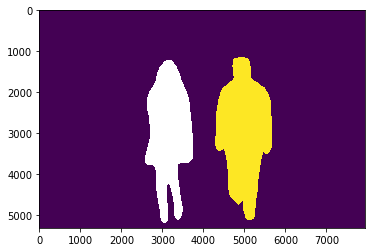

In [11]:
import numpy.ma as ma

combined_masks = ma.masked_array(masks[0] > 0, masks[1])
plt.imshow(combined_masks)
plt.show()

--2019-12-02 04:01:56--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘mrcnn_standing_people.jpg’

mrcnn_standing_peop 100%[===================>]   1.83M  1.91MB/s    in 1.0s    

2019-12-02 04:02:02 (1.91 MB/s) - ‘mrcnn_standing_people.jpg’ saved [1923610/1923610]



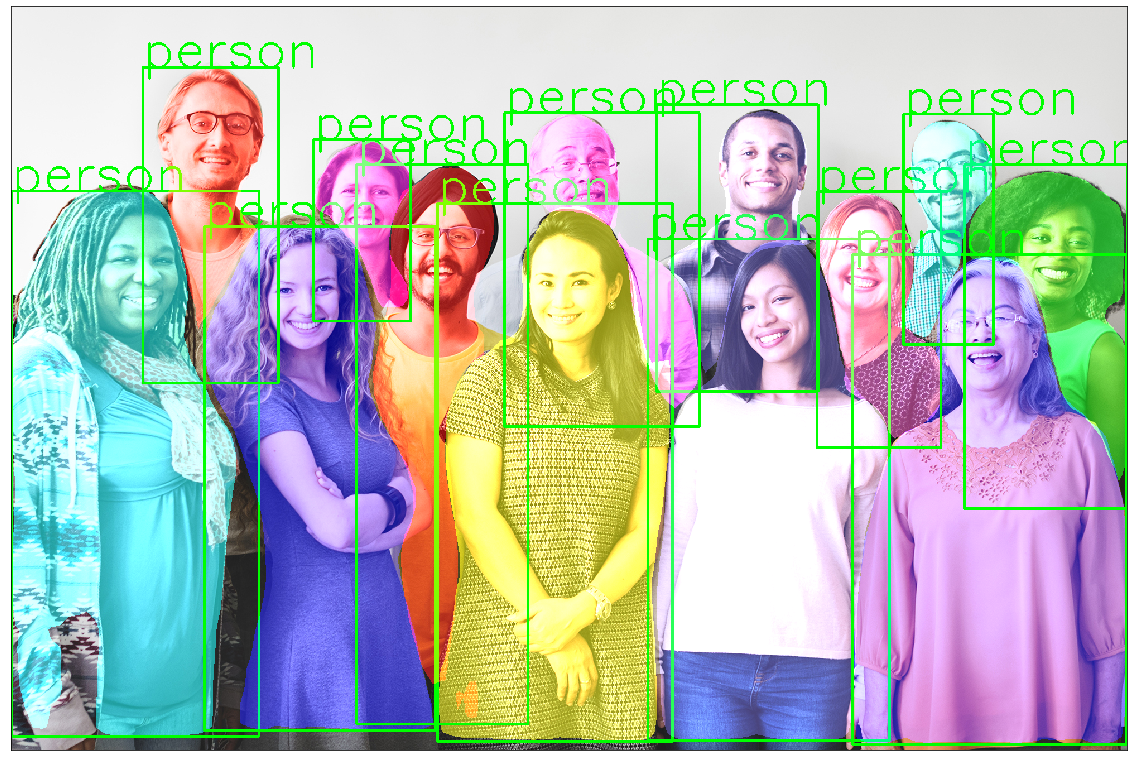

In [16]:
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O mrcnn_standing_people.jpg
instance_segmentation_api('./mrcnn_standing_people.jpg', 0.75)

--2019-12-02 04:03:27--  https://cff2.earth.com/uploads/2019/04/18174234/Why-do-some-animals-eat-their-young--730x410.jpg
Resolving cff2.earth.com (cff2.earth.com)... 143.204.142.83, 143.204.142.126, 143.204.142.11, ...
Connecting to cff2.earth.com (cff2.earth.com)|143.204.142.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27647 (27K) [image/jpeg]
Saving to: ‘mrcnn_birds.jpg’

mrcnn_birds.jpg     100%[===================>]  27.00K  --.-KB/s    in 0.006s  

2019-12-02 04:03:31 (4.31 MB/s) - ‘mrcnn_birds.jpg’ saved [27647/27647]



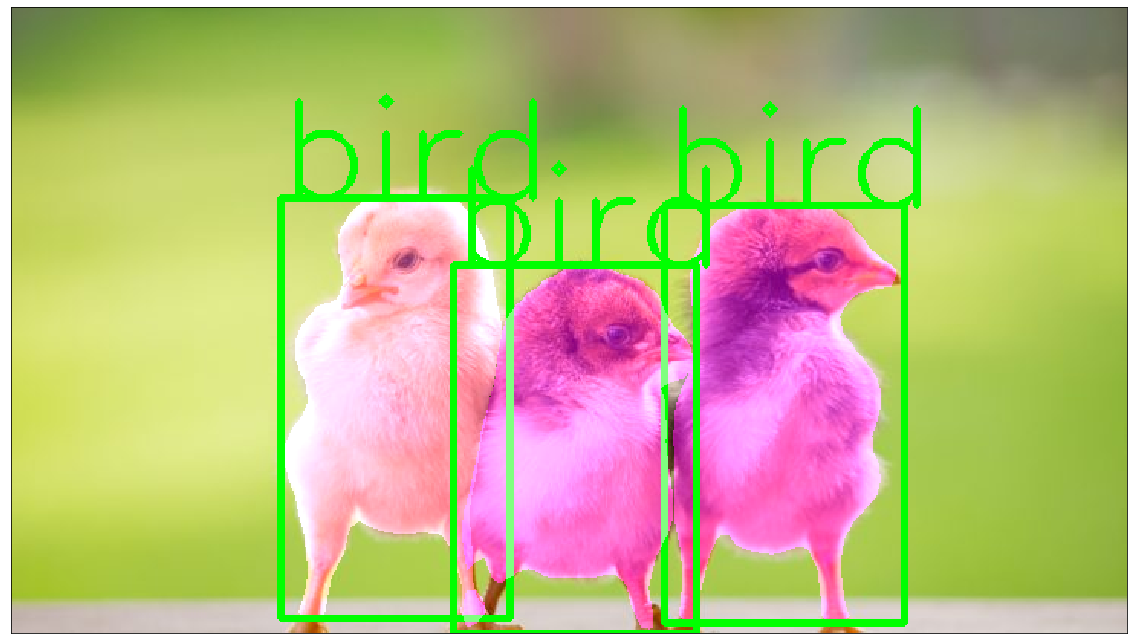

In [17]:
!wget https://cff2.earth.com/uploads/2019/04/18174234/Why-do-some-animals-eat-their-young--730x410.jpg -O mrcnn_birds.jpg
instance_segmentation_api('./mrcnn_birds.jpg', 0.9)

--2019-12-02 04:33:03--  https://images.unsplash.com/photo-1543205764-fee67cf76589
Resolving images.unsplash.com (images.unsplash.com)... 2a04:4e42:5::720, 151.101.22.208
Connecting to images.unsplash.com (images.unsplash.com)|2a04:4e42:5::720|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 801495 (783K) [image/jpeg]
Saving to: ‘mrcnn_baby_teddy.jpg’

mrcnn_baby_teddy.jp 100%[===================>] 782.71K  --.-KB/s    in 0.1s    

2019-12-02 04:33:04 (6.61 MB/s) - ‘mrcnn_baby_teddy.jpg’ saved [801495/801495]



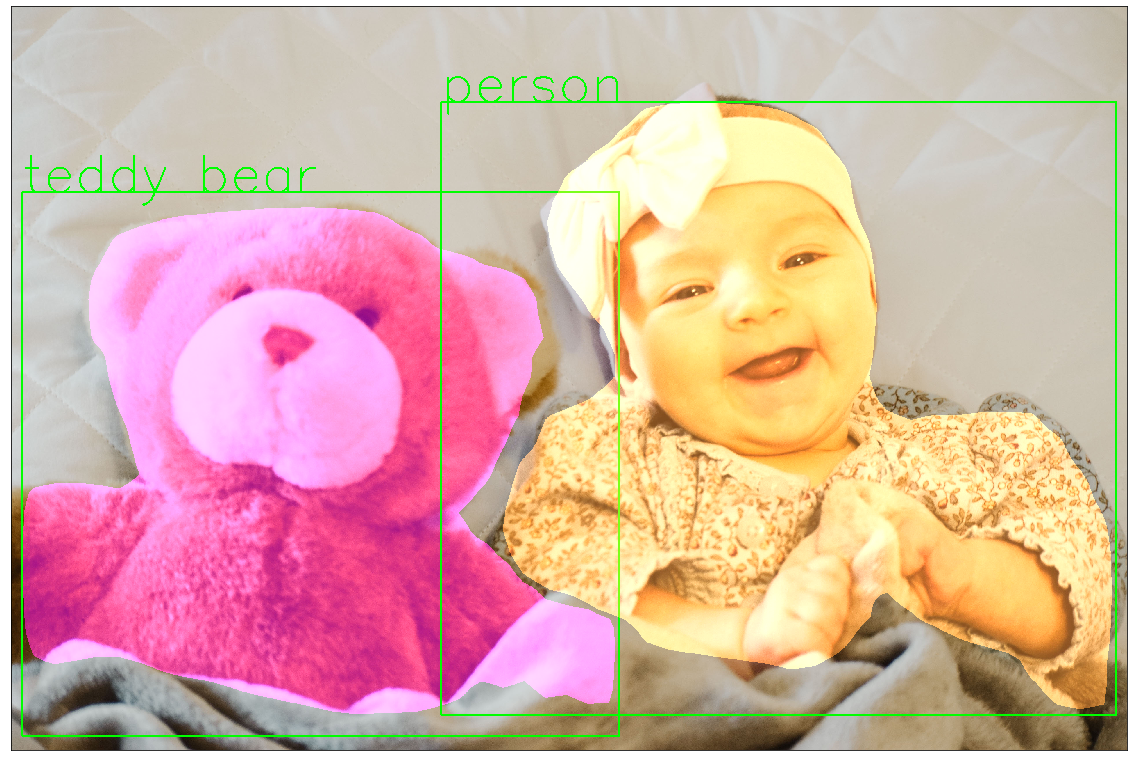

In [19]:
!wget https://images.unsplash.com/photo-1543205764-fee67cf76589 -O mrcnn_baby_teddy.jpg
instance_segmentation_api('./mrcnn_baby_teddy.jpg', 0.95, rect_th=6, text_size=6, text_th=6)